# Nakaam Mushrooms - A Deeplearning project to tell poisonous and non-poisonous mushrooms apart

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2024-08-03 12:51:39.558673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 12:51:39.558780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 12:51:39.673905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Importing Data

In [2]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', low_memory=False)
test_data.drop_duplicates(inplace = True)
test_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [3]:
df = test_data.sample(50000)

final_test_df = test_data.sample(500)

In [4]:
df.isnull().sum()

id                          0
class                       0
cap-diameter                0
cap-shape                   1
cap-surface             10800
cap-color                   1
does-bruise-or-bleed        0
gill-attachment          8443
gill-spacing            20029
gill-color                  1
stem-height                 0
stem-width                  0
stem-root               44248
stem-surface            31884
stem-color                  1
veil-type               47445
veil-color              44047
has-ring                    0
ring-type                1947
spore-print-color       45745
habitat                     1
season                      0
dtype: int64

## Encoding/standardisation of data

In [5]:
label_encode = ['class']

cat_cols = [
    'cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color',
    'stem-color', 'has-ring', 'ring-type', 'habitat', 'season'
]

num_cols = [
    'cap-diameter', 'stem-height', 'stem-width'
]

columns_to_drop = [
    'id',
    'cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 
    'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'
]

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['class'])
df.drop(columns = columns_to_drop, inplace = True)

### Preprocessing Pipeline

In [7]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)


def fit_pipeline(df, target):
    X = df.drop(columns=[target])
    y = df[target]

    preprocessor.fit(X)
    
    X_transformed = preprocessor.transform(X)

    selector = SelectKBest(score_func=f_classif, k=20)
    selector.fit(X_transformed, y)
    
    return preprocessor, selector

def transform_pipeline(df, preprocessor, selector):

    X_transformed = preprocessor.transform(df)

    X_selected = selector.transform(X_transformed)
    
    num_col_names = num_cols
    cat_col_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
    all_col_names = list(num_col_names) + list(cat_col_names)
    selected_features = selector.get_support(indices=True)
    selected_col_names = [all_col_names[i] for i in selected_features]

    transformed_df = pd.DataFrame(X_selected, columns=selected_col_names)
    
    return transformed_df

preprocessor, selector = fit_pipeline(df, 'class')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
df.drop(columns = ['class'], inplace = True)
df = transform_pipeline(df, preprocessor, selector)
df['class'] = y

In [9]:
df

,cap-diameter,stem-width,cap-shape_b,cap-shape_x,cap-color_b,cap-color_e,cap-color_n,cap-color_o,cap-color_r,gill-color_n,...,stem-color_n,stem-color_p,stem-color_w,stem-color_y,ring-type_z,habitat_g,habitat_l,habitat_w,season_w,class
0,-1.113859,-1.050887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,-0.195471,-0.662432,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.592935,1.690423,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-1.054196,-1.076702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-1.045672,-1.171357,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-1.026495,-1.179962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49996,0.469347,0.655363,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49997,-0.506572,-0.450995,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49998,-0.536404,-0.041642,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Correlation Heatmap

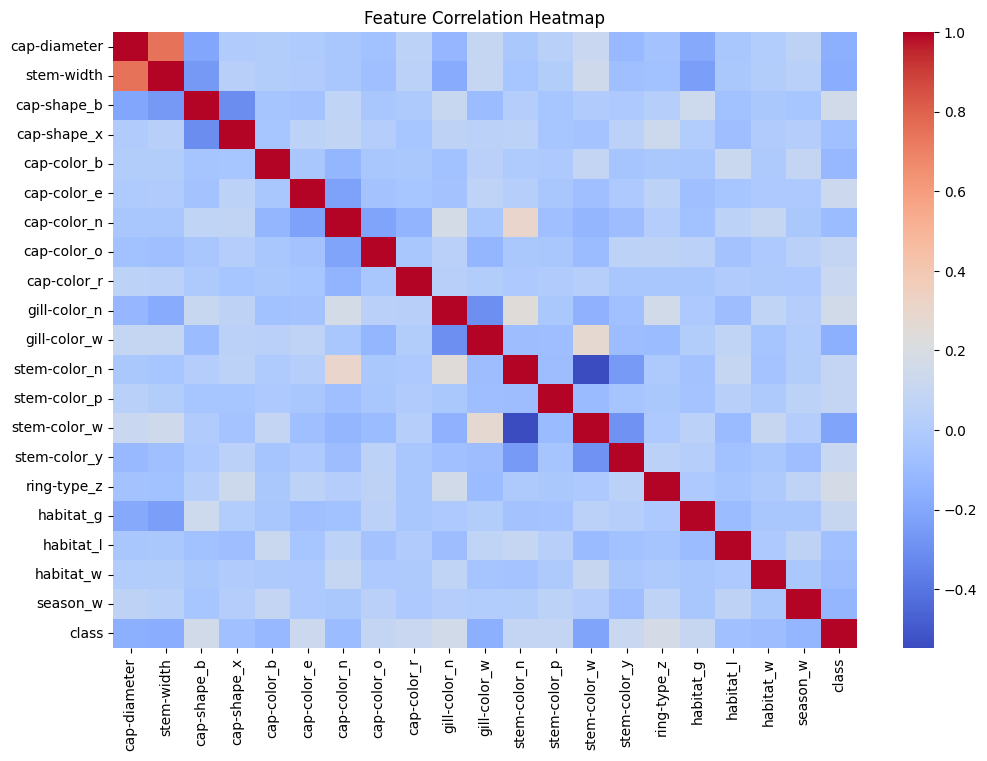

In [10]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [11]:
l = df.shape[1]
col = []
for i in range(l-1):
    col.append(i)
    
df.columns = col + ['target']

## Applying Models

In [12]:
pAUCscores = []
confMatrix = []
cfReport = []

### Model Evaluation Parameter

In [13]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

### LGBM Classifier

In [14]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

y_scores = lgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_scores > 0.5).astype(int)

solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_test, y_pred))
cfReport.append(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 22019, number of negative: 17981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550475 -> initscore=0.202590
[LightGBM] [Info] Start training from score 0.202590


### XGB Clasifier

In [15]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_scores = xgb_model.predict_proba(X_test)[:, 1]
y_true = y_test
y_pred = (y_scores > 0.5).astype(int)

solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_test, y_pred))
cfReport.append(classification_report(y_test, y_pred))

### CatBoost Clasifier

In [16]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)
y_true = y_test
y_scores = catboost_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### AdaBoost Classifier

In [17]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)

y_pred = adaboost_model.predict(X_test)
y_scores = adaboost_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
conf_matrix = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

pAUCscores.append(pAUC)
confMatrix.append(conf_matrix)
cfReport.append(cf_report)

### GBR Classifier

In [18]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)

y_pred = gbm_model.predict(X_test)
y_true = y_test

y_scores = gbm_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### SVM Classifier

In [19]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_true = y_test

y_scores = svm_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))


### Random Forest Classifier

In [20]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
y_true = y_test

y_scores = random_forest_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### Deep Neural Networks

In [21]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],),),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=40, validation_split=0.2, batch_size=64, verbose=3)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

y_scores = model.predict(X_test).flatten()

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


I0000 00:00:1722689762.288802      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - loss: 0.2875
Test Accuracy: 0.883400022983551
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


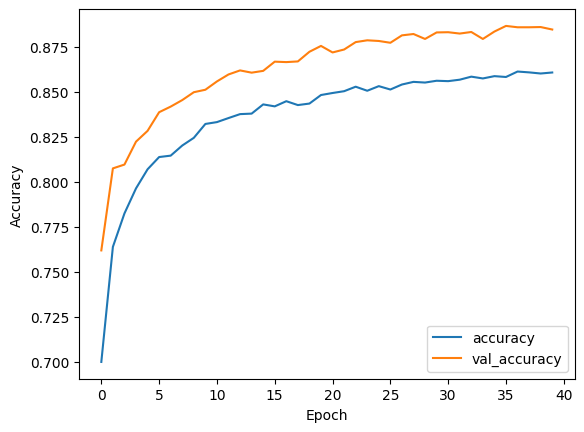

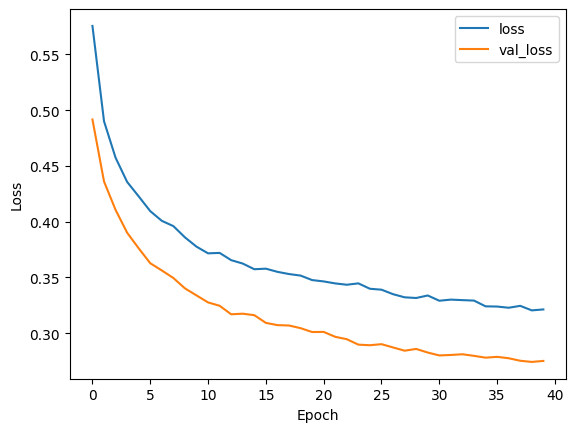

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
'''pAUCscores.pop(-1)
confMatrix.pop(-1)
cfReport.pop(-1)'''

'pAUCscores.pop(-1)\nconfMatrix.pop(-1)\ncfReport.pop(-1)'

## Models Evaluation

In [24]:
models = ['LGBM', 'XGB', 'CAT', 'ADB', 'GBM', 'SVM', 'RF', 'DNN']

for ps, conf, cf, md in zip(pAUCscores, confMatrix, cfReport, models):
    print('----------------------------------')
    print('Metrics for', md)
    print('pAUC Score:\n', ps)
    print('Confusion Matrix:\n', conf)
    print('Other Metrics Report:\n', cf)

----------------------------------
Metrics for LGBM
pAUC Score:
 0.16878330084097418
Confusion Matrix:
 [[4195  384]
 [ 646 4775]]
Other Metrics Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4579
           1       0.93      0.88      0.90      5421

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

----------------------------------
Metrics for XGB
pAUC Score:
 0.17449059147695864
Confusion Matrix:
 [[4218  361]
 [ 507 4914]]
Other Metrics Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      4579
           1       0.93      0.91      0.92      5421

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

----------------------------------
Metr

## Best Model

In [25]:
import pandas as pd

def predict(test_data: pd.DataFrame, model_, return_actual=False) -> pd.DataFrame:
    ids = test_data['id']
    
    test_data_processed = transform_pipeline(test_data, preprocessor, selector)
    
    test_data_processed.columns = col
    
    try:
        test_predictions = model_.predict_proba(test_data_processed)[:, 1]
    except:
        test_predictions = model_.predict(test_data_processed).flatten()
    
    predictions_df = pd.DataFrame({'id': ids, 'target': test_predictions})
    
    if return_actual:
        res = []
        for _, row in predictions_df.iterrows():
            if row['target'] > 0.5:
                res.append('p')
            else:
                res.append('e')
        predictions_df['target'] = res
    
    return predictions_df


X = final_test_df.drop(columns = ['class'])
y = le.transform(final_test_df['class'])

mdls = [lgb_model, xgb_model, catboost_model, adaboost_model, gbm_model, svm_model, random_forest_model, model]
mdls_name = ['lgb_model','xgb_model', 'catboost_model', 'adaboost_model', 'gbm_model', 'svm_model', 'random_forest_model', 'dnn']

best_model = None
best_model_name = None
max_puac = 0
sum_puac = 0
for m, n in zip(mdls, mdls_name):
    print(n)
    predicted_df = predict(X, m)
    
    predicted_df['actual_target'] = y
    solution = pd.DataFrame({'row_id': range(len(predicted_df['actual_target'])), 'target': predicted_df['actual_target']})
    submission = pd.DataFrame({'row_id': range(len(predicted_df['target'])), 'prediction': predicted_df['target']})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    print(pAUC)
        
    sum_puac += pAUC
    if(pAUC > max_puac):
        max_puac = pAUC
        best_model = m
        best_model_name = n


print(f'Best pAUC Model: {best_model_name}')
print(f'Average pAUC:{sum_puac/len(mdls)}')

lgb_model
0.1579927739863508
xgb_model
0.16649538338016856
catboost_model
0.16924929747089518
adaboost_model
0.08863107185869126
gbm_model
0.11283018867924523
svm_model
0.1399277398635086
random_forest_model
0.16374949819349655
dnn
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.15555198715375346
Best pAUC Model: catboost_model
Average pAUC:0.1443034925732637


## Final Predictions

In [26]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', low_memory=False)
predicted_df = predict(test_data, best_model, return_actual = True)
predicted_df.to_csv('submission.csv', index=False)
predicted_df

,id,target
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
